In [1]:
import pyreadr
import pandas as pd

# 讀取資料
result = pyreadr.read_r('airqual.rds')
dat = result[None]  # 取出 DataFrame

# 保留需要的欄位
keep_column = ["SHORT_NAME", "LATITUDE", "LONGITUDE", "OZDLYAV"]
dat = dat[keep_column]

In [2]:
import geopandas as gpd
from pyproj import CRS

# 建立 GeoDataFrame
gdf = gpd.GeoDataFrame(dat, geometry=gpd.points_from_xy(dat['LONGITUDE'], dat['LATITUDE']), crs='EPSG:4326')

# 轉換為 UTM Zone 10N
gdf = gdf.to_crs(epsg=32610)

# 拆解轉換後的座標
gdf['x1'] = gdf.geometry.x
gdf['x2'] = gdf.geometry.y
gdf['y'] = gdf['OZDLYAV']


In [6]:
import geopandas as gpd

# 讀取剛剛用 R 存下的 geojson
ca_gdf = gpd.read_file("ca_map.geojson")

# 投影到 UTM Zone 10N
ca_gdf = ca_gdf.to_crs(epsg=32610)


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 建立訓練資料
X = gdf[['x1', 'x2']].values
y = gdf['y'].values * 1000  # 乘 1000

# 建立迴歸模型
model = LinearRegression()
model.fit(X, y)

# 建立預測網格
xmin, ymin, xmax, ymax = ca_gdf.total_bounds
grid_x, grid_y = np.meshgrid(np.arange(xmin, xmax, 10000), np.arange(ymin, ymax, 10000))
grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])

# 預測
y_pred = model.predict(grid_coords)



In [10]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
ols_model = sm.OLS(y, X2).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     76.11
Date:                Fri, 16 May 2025   Prob (F-statistic):           3.44e-29
Time:                        12:09:34   Log-Likelihood:                -1625.2
No. Observations:                 452   AIC:                             3256.
Df Residuals:                     449   BIC:                             3269.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -84.9313     15.216     -5.582      0.0

(333602.68145021144, 1364204.668618627, 3542248.380600912, 4706508.964966857)

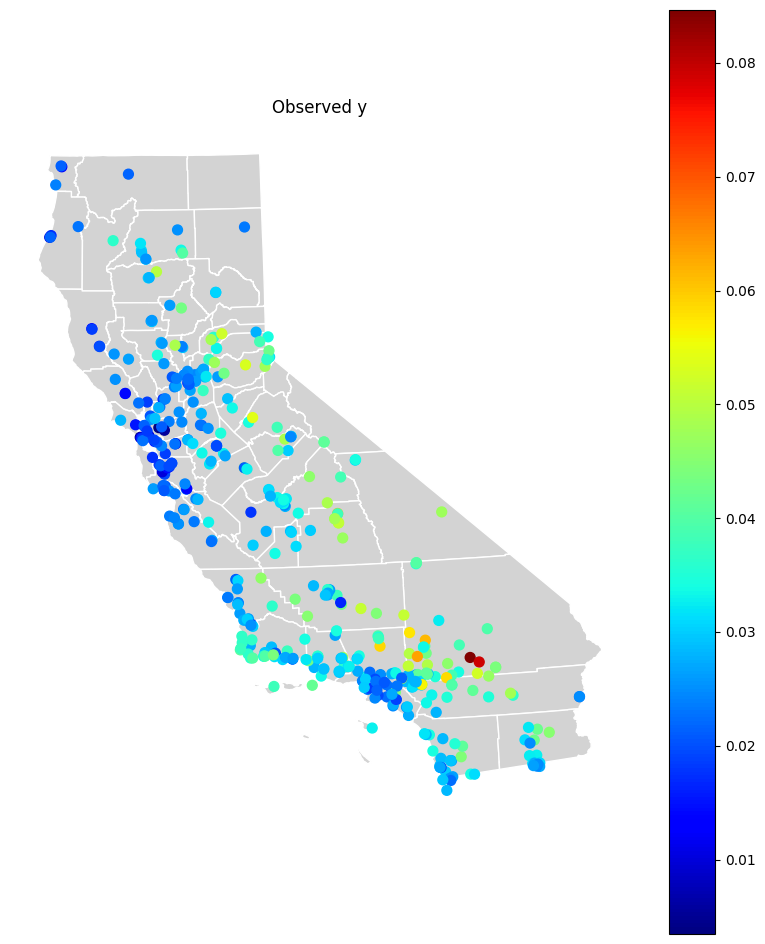

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# (1) 空間點圖
fig, ax = plt.subplots(figsize=(10, 12))
ca_gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.plot(ax=ax, column='y', cmap='jet', markersize=50, legend=True)
plt.title("Observed y")
plt.axis('off')



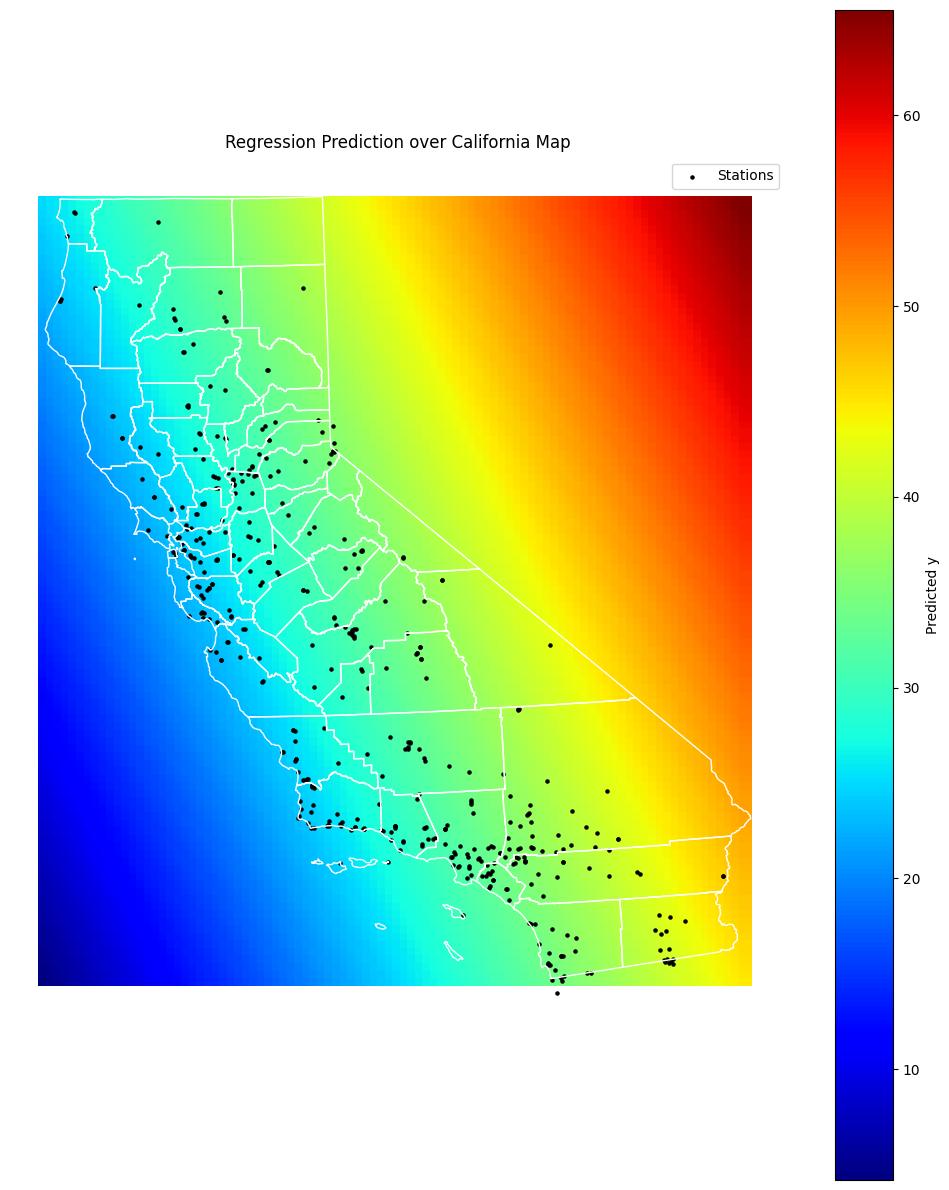

In [ ]:
# import matplotlib.pyplot as plt
# import geopandas as gpd

# 1. 建立地圖底圖
fig, ax = plt.subplots(figsize=(10, 12))

# 2. 加上預測結果散點圖 (以格點為底)
sc = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=y_pred, cmap='jet',
                s=100, marker='s', edgecolor='none')  # marker='s' 表示小方格
plt.colorbar(sc, ax=ax, label='Predicted y')

# 3. 可選：加上實際測站位置作為點
gdf.plot(ax=ax, color='black', markersize=5, label='Stations')
ca_gdf.plot(ax=ax, color='#FF000000', edgecolor='white') #transparent background

# 4. 顯示標題與圖例
plt.title("Regression Prediction over California Map")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

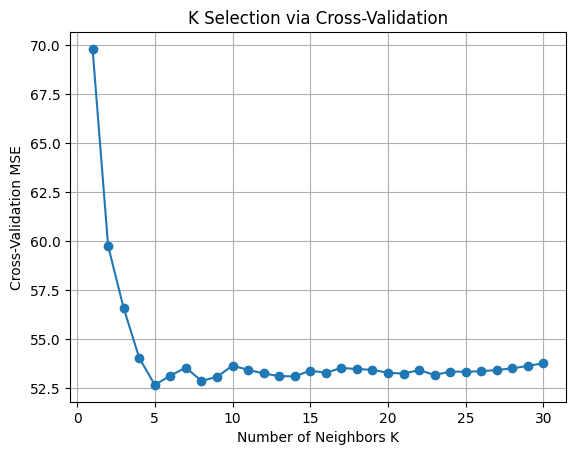

Best K found: 5


In [35]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# 用來做交叉驗證找最佳K
X_train = gdf[['x1', 'x2']].values
y_train = (gdf['y'] * 1000).values  # same scale as R

cv_scores = []
k_range = range(1, 31)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', algorithm='auto') #, p=1) p,default=2, use Euclidean distance
    # 使用負MSE做為分數（越大越好）
    scores = cross_val_score(knn, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    cv_scores.append(-scores.mean())

# 繪製交叉驗證分數 vs k
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel("Number of Neighbors K")
plt.ylabel("Cross-Validation MSE")
plt.title("K Selection via Cross-Validation")
plt.grid(True)
plt.show()

# 找到最佳 K
best_k = k_range[np.argmin(cv_scores)]
print("Best K found:", best_k)


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # Manhattan vs Euclidean
    'algorithm': ['auto']
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

best_knn = grid_search.best_estimator_
grid_pred = best_knn.predict(grid_coords)


Best parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best MSE: 52.154449814149245


In [36]:
# 訓練模型並對 grids 做預測
print("Best K found:", best_k)
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

grid_pred = knn_final.predict(grid_coords)


Best K found: 5


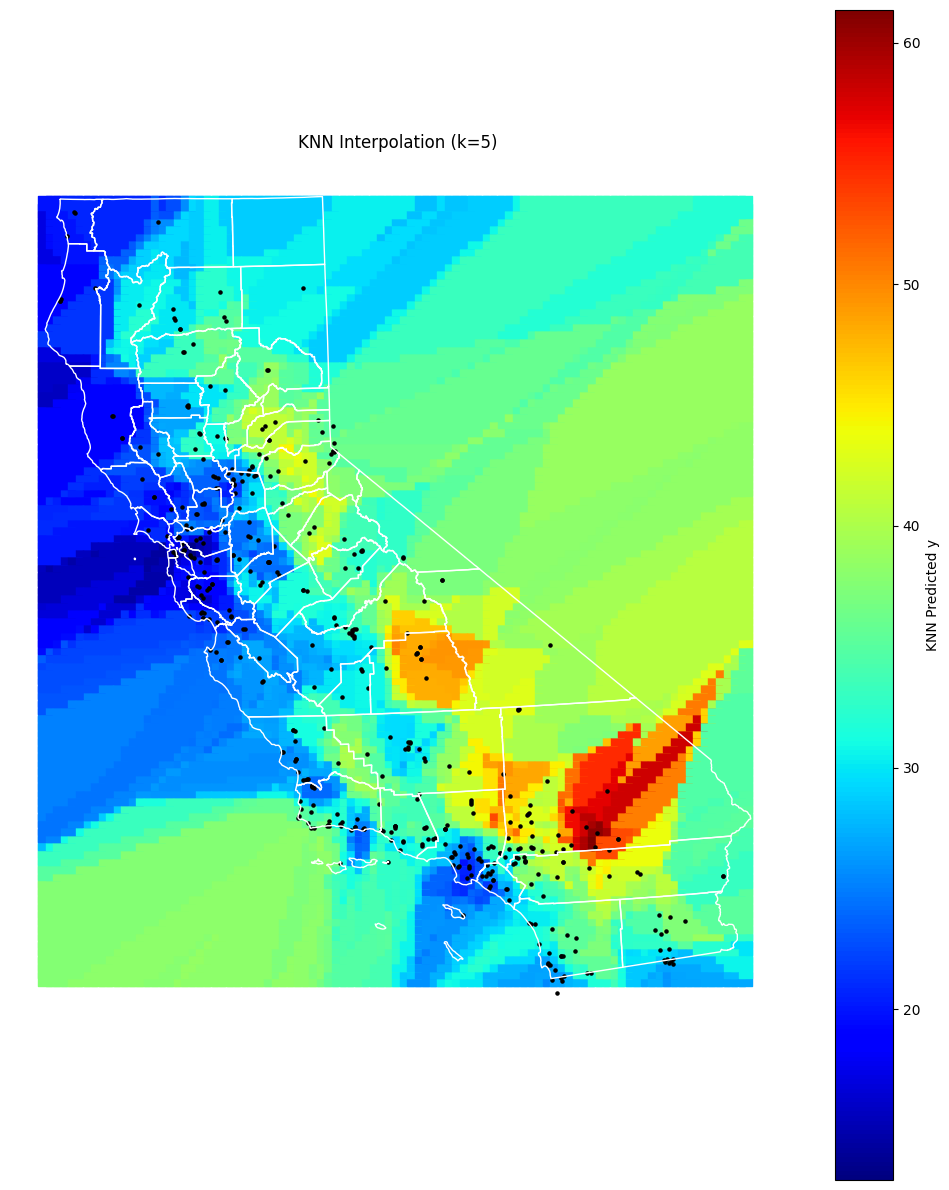

In [37]:
fig, ax = plt.subplots(figsize=(10, 12))

# (1) 加州背景透明疊圖
sc = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=grid_pred,
                cmap='jet', s=100, marker='s')
plt.colorbar(sc, ax=ax, label='KNN Predicted y')

# (2) 疊加測站點 + 地圖邊界
gdf.plot(ax=ax, color='black', markersize=5, label='Stations')
ca_gdf.plot(ax=ax, color='#FF000000', edgecolor='white')

plt.title(f"KNN Interpolation (k={best_k})")
plt.axis('off')
plt.tight_layout()
plt.show()


In [38]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# 將格點與預測值合併為 DataFrame
grid_df = pd.DataFrame(grid_coords, columns=['x1', 'x2'])
grid_df['yhat'] = grid_pred

# 轉為 GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df['x1'], grid_df['x2']), crs='EPSG:32610')

# 過濾只保留在 CA 多邊形內的格點
# 若 ca_gdf 有多個 polygon，先合併成一個
ca_union = ca_gdf.unary_union
grid_within_ca = grid_gdf[grid_gdf.within(ca_union)]


C:\Users\bioer\AppData\Local\Temp\ipykernel_15724\1480724340.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ca_union = ca_gdf.unary_union


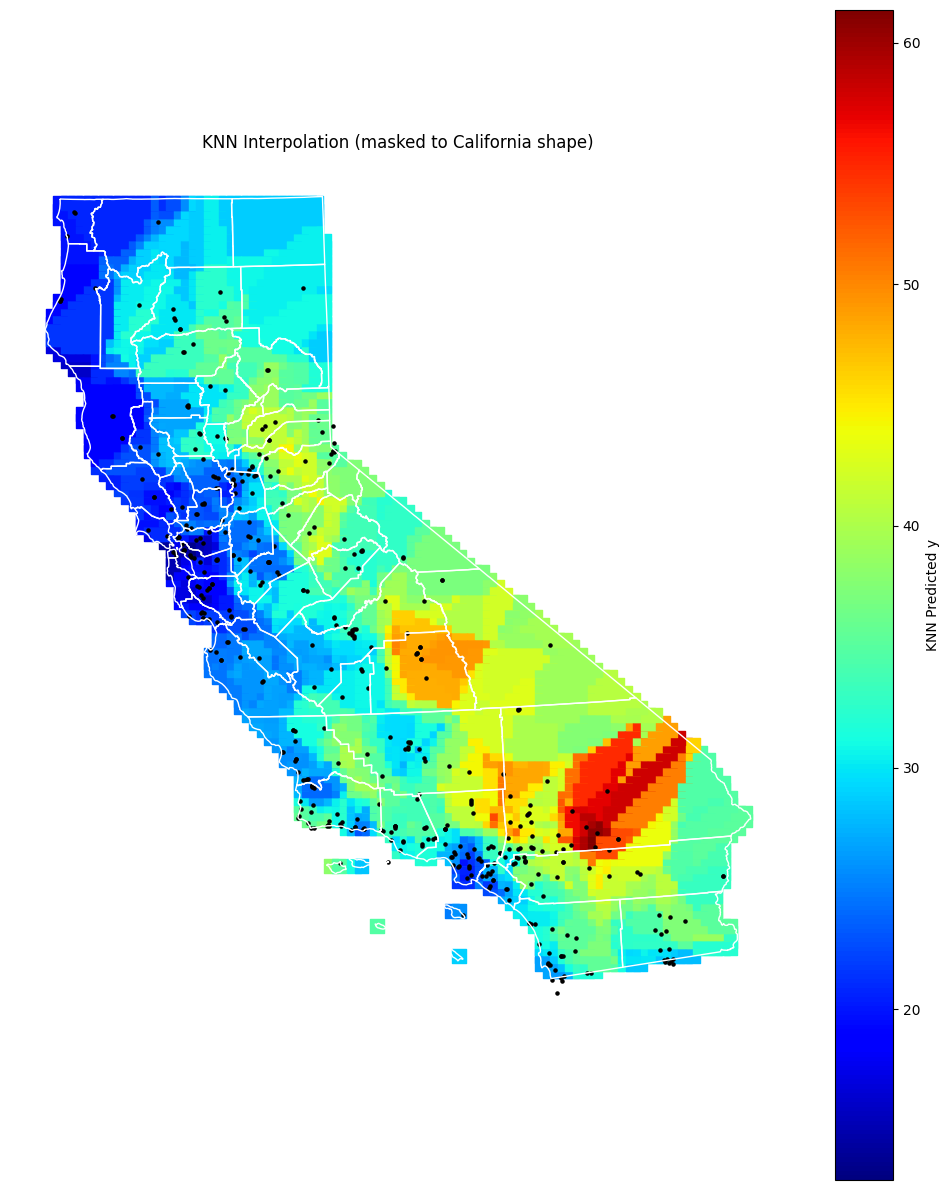

In [39]:
fig, ax = plt.subplots(figsize=(10, 12))

# 繪製經過裁切的預測格點
sc = ax.scatter(grid_within_ca['x1'], grid_within_ca['x2'], c=grid_within_ca['yhat'],
                cmap='jet', s=100, marker='s')
plt.colorbar(sc, ax=ax, label='KNN Predicted y')

# 疊加測站點與加州邊界
gdf.plot(ax=ax, color='black', markersize=5, label='Stations')
ca_gdf.plot(ax=ax, color='#FF000000', edgecolor='white')

plt.title(f"KNN Interpolation (masked to California shape)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# 準備訓練資料（x1, x2）與 y
X_train = gdf[['x1', 'x2']].values
y_train = (gdf['y'] * 1000).values  # 若你有乘 1000，如 R 的範例

In [63]:
from sklearn.preprocessing import StandardScaler

# 標準化輸入資料（強烈建議！）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 同樣對預測點標準化
grid_scaled = scaler.transform(grid_coords)

# 使用手動 bandwidth，例如 bw=0.5（以標準化後尺度設定）
kr = KernelReg(endog=y_train, exog=X_scaled, var_type='cc', bw=[0.5, 0.5])
yhat_grid, _ = kr.fit(grid_scaled)


In [64]:
kr_auto = KernelReg(endog=y_train, exog=X_train, var_type='cc')
print("Auto bandwidth:", kr_auto.bw)

Auto bandwidth: [64907.6711214  26374.51936311]


In [67]:
grid_coords_array = grid_coords  # shape: [n, 2] with x1, x2
yhat_grid, _ = kr_auto.fit(grid_coords_array) 


In [68]:
grid_df = pd.DataFrame(grid_coords_array, columns=['x1', 'x2'])
grid_df['yhat'] = yhat_grid

# 過濾只保留在加州邊界範圍內的預測點
from shapely.geometry import Point
grid_df['geometry'] = [Point(xy) for xy in zip(grid_df['x1'], grid_df['x2'])]
grid_gdf = gpd.GeoDataFrame(grid_df, geometry='geometry', crs='EPSG:32610')
grid_gdf = grid_gdf[grid_gdf.within(ca_gdf.unary_union)]


C:\Users\bioer\AppData\Local\Temp\ipykernel_15724\202106027.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.within(ca_gdf.unary_union)]


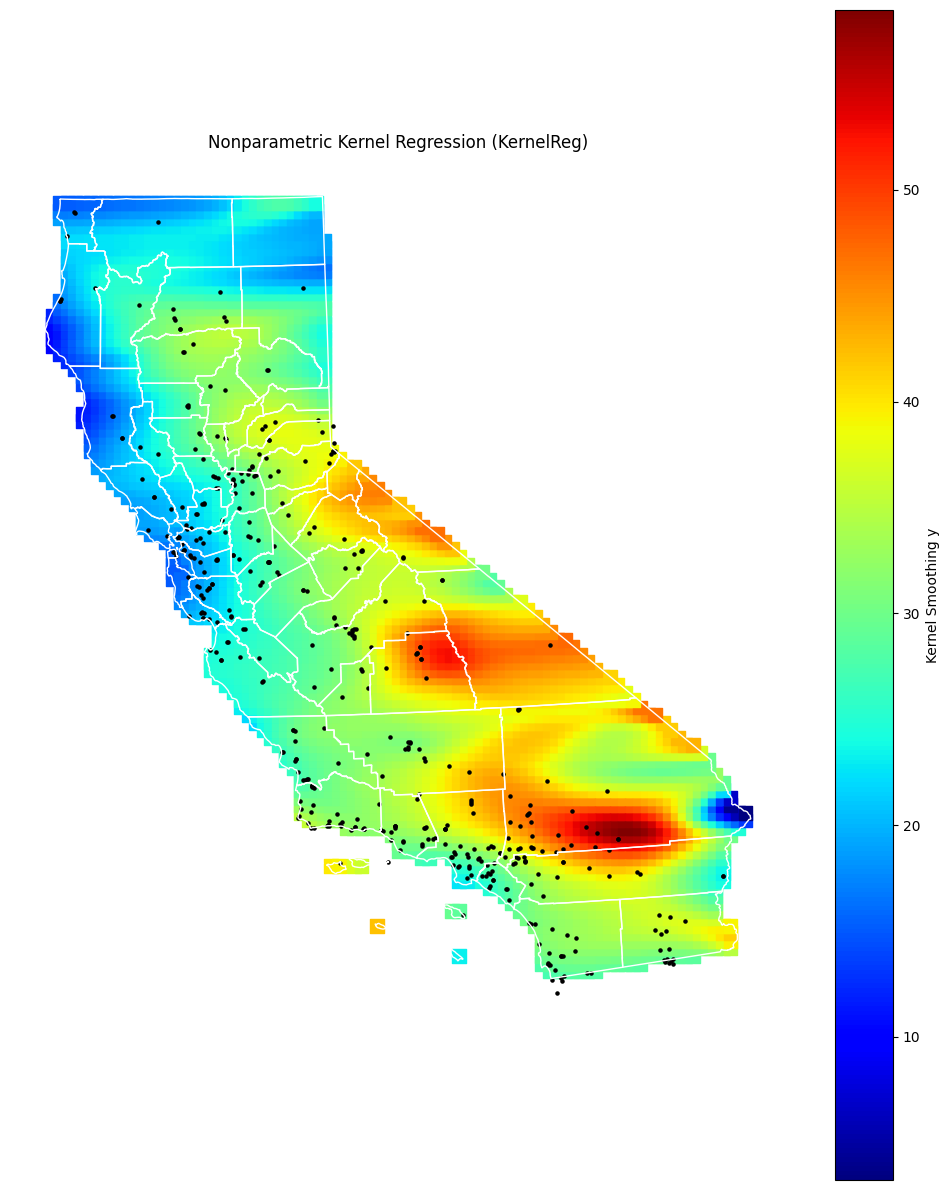

In [69]:
fig, ax = plt.subplots(figsize=(10, 12))

# 插值色塊
sc = ax.scatter(grid_gdf['x1'], grid_gdf['x2'], c=grid_gdf['yhat'],
                cmap='jet', s=100, marker='s')
plt.colorbar(sc, ax=ax, label='Kernel Smoothing y')

# 疊加測站與加州圖層
gdf.plot(ax=ax, color='black', markersize=5)
ca_gdf.plot(ax=ax, color='#FF000000', edgecolor='white')

plt.title('Nonparametric Kernel Regression (KernelReg)')
plt.axis('off')
plt.tight_layout()
plt.show()
